In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [205]:
df = pd.read_csv('customers_data.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

cols = df.dtypes[df.dtypes == 'object'].index.to_list()

for i in cols:
    df[i] = df[i].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [206]:
full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
train_data, valid = train_test_split(df, test_size=0.33, random_state=11)

y_train = train_data.churn.values
y_valid = valid.churn.values

del train_data['churn']
del valid['churn']

In [207]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [208]:
train_dict = train_data[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [209]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [210]:
valid_dict = valid[categorical + numerical].to_dict(orient='records')
X_valid = dv.transform(valid_dict)

In [211]:
small_subset = ['contract', 'tenure', 'totalcharges']
small_set = train_data[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(small_set)
X_smallTrain = dv_small.transform(small_set)

In [212]:
model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_smallTrain, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [213]:
small_valid = valid[small_subset].to_dict(orient='records')
X_smallValid = dv.transform(small_valid)

# Accuracy

In [264]:
y_plot = model.predict_proba(X_valid)
y_pred = model.predict_proba(X_valid)[:, 1]

In [215]:
y_churn = y_pred >= 0.5
round((y_valid == y_churn).mean(), 2)

0.79

In [41]:
# However we can do accuracy with the help of Sklearn
from sklearn.metrics import accuracy_score

In [42]:
round(accuracy_score(y_pred >= 0.5, y_valid), 2)

0.79

In [43]:
# np.linspace(start, stop, num)
threshold_one = np.linspace(0, 1, 11)
threshold_two = np.linspace(0, 1, 21)
threshold_one

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [44]:
# generally, 0.5 is good enough, but we need to check
# for possible better accuracy
res = []

for t in [threshold_one, threshold_two]:
    for i in t:
        y_ch = y_pred >= i
        accuracy = accuracy_score(y_ch, y_valid)
        res.append(accuracy)
        print('%0.2f %0.3f' %(i, accuracy))
    
    print('End of first')

0.00 0.271
0.10 0.614
0.20 0.705
0.30 0.770
0.40 0.792
0.50 0.794
0.60 0.791
0.70 0.766
0.80 0.735
0.90 0.729
1.00 0.729
End of first
0.00 0.271
0.05 0.526
0.10 0.614
0.15 0.668
0.20 0.705
0.25 0.744
0.30 0.770
0.35 0.782
0.40 0.792
0.45 0.796
0.50 0.794
0.55 0.801
0.60 0.791
0.65 0.782
0.70 0.766
0.75 0.748
0.80 0.735
0.85 0.729
0.90 0.729
0.95 0.729
1.00 0.729
End of first


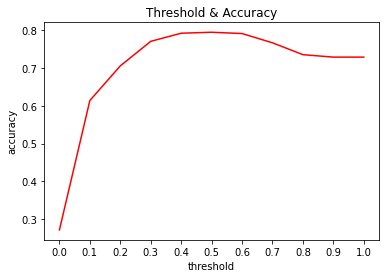

In [45]:
plt.figure(figsize=(6, 4))
plt.plot(threshold_one, res[0:11], color='red')
plt.title('Threshold & Accuracy')
plt.xlabel('threshold')
plt.ylabel('accuracy')

plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [46]:
y_predictSmall = model.predict_proba(X_smallValid)[:, 1]
y_churn_small = y_predictSmall >= 0.5
# `y_churn_small` is True/False values

In [47]:
round((y_valid == y_churn_small).mean(), 2)

0.76

In [48]:
round(accuracy_score(y_valid, y_churn_small), 2)

0.76

# Dummy Baseline

In [49]:
length = len(y_valid)
baseline = np.repeat(False, length)
baseline

array([False, False, False, ..., False, False, False])

In [50]:
round(accuracy_score(baseline, y_valid), 2)

0.73

# Confusion table

In [51]:
# () inside () are essential
true_pos = ((y_pred >= 0.5) & (y_valid == 1)).sum()
true_neg = ((y_pred < 0.5) & (y_valid == 0)).sum()
false_pos = ((y_pred >= 0.5) & (y_valid == 0)).sum()
false_neg = ((y_pred < 0.5) & (y_valid == 1)).sum()
# `sum()` casts False & True to bool, then sum 1.
# Similar behaviour is seen in `mean()`

In [52]:
conf_table = np.array(
    # pred. pos. pred. neg. 
    [
    [true_pos, false_neg], # actual positive
    [false_pos, true_neg]  # actual negative
    ])

In [53]:
conf_table

array([[ 330,  301],
       [ 177, 1517]])

In [54]:
conf_table * 100 / conf_table.sum()
# false_neg & false_pos are the errors of our model.
# We see that approx. 12.95% wrong when customer was positive
# but model decided negative. Approx. 7.61% when customer was
# negative but model decides positive

array([[14.19354839, 12.94623656],
       [ 7.61290323, 65.24731183]])

In [55]:
# if we take true_positive & true_negative / all data
# from the table -> we receive model
(65.25 + 14.2)/(14.2 + 12.95 + 7.61 + 65.25)

0.7944205579442056

In [56]:
true_pos_s = ((y_predictSmall >= 0.5) & (y_valid == 1)).sum()
true_neg_s = ((y_predictSmall < 0.5) & (y_valid == 0)).sum()
false_pos_s = ((y_predictSmall >= 0.5) & (y_valid == 0)).sum()
false_neg_s = ((y_predictSmall < 0.5) & (y_valid == 1)).sum()

In [57]:
conf_table_s = np.array(
     # pred. pos. pred. neg. 
    [
    [true_pos_s, false_neg_s],   # actual positive
    [false_pos_s, true_neg_s]    # actual negative
    ]
)

In [58]:
conf_table_s

array([[ 338,  293],
       [ 264, 1430]])

In [59]:
conf_table_s * 100 / conf_table.sum()

array([[14.53763441, 12.60215054],
       [11.35483871, 61.50537634]])

In [60]:
(61.5 + 14.54) / (61.5 + 14.54 + 12.6 + 11.35)

0.7604760476047605

In [61]:
(65.24731183 - 61.50537634) + (14.19354839 - 14.53763441)
# is the difference in the two models: 76 vs 73.
# Small model predicts worse when we deal with
# users who've actually not churned.
# We need to look at true_pos/neg and
# see that the difference is there

3.3978494700000024

# Precision and Recall

In [62]:
# Precision.
# P = TP / (TP + FP)
# i.e. fraction of positive predictions to be correct
330 / (330 + 177) # denominator is: predicted positive

0.650887573964497

In [63]:
# Recall
# R = TP / (TP + FN). False Negative - pred. no-churn actual churn
330 / (330 + 301) # denominator is: actual positive

0.5229793977812995

# Precision & Recall for various thresholds
<h3>
   As we have intersection between prec. & recall,
    we'll calc. f1 score to see the best threshold.
    Best - maximizes it.
    We'll incorporate it in our function
</h3>

In [220]:
def calc_prec_rec(y_vl, y_pred):
    thresholds = np.linspace(0, 1, 11)
    
    scores = []
    for t in thresholds:
        true_positive = ((y_pred >= t) & (y_vl == 1)).sum()
        true_negative = ((y_pred < t) & (y_vl == 0)).sum()
        false_positive = ((y_pred >= t) & (y_vl == 0)).sum()
        false_negative = ((y_pred < t) & (y_vl == 1)).sum()
        scores.append([t, true_positive, true_negative,
                         false_positive, false_negative])
    
    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
    df_scores['precision'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])
    df_scores['recall'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
    df_scores['f1'] = (2 * df_pr_r['precision'] * df_pr_r['recall'])\
                        / (df_pr_r['precision'] + df_pr_r['recall'])
    
    return df_scores

In [221]:
df_pr_r = calc_prec_rec(y_valid, y_pred)
df_pr_r

,threshold,tp,tn,fp,fn,precision,recall,f1
0,0.0,631,0,1694,0,0.271398,1.000000,0.400568
1,0.1,593,834,860,38,0.408121,0.939778,0.548780
2,0.2,537,1103,591,94,0.476064,0.851030,0.609337
3,0.3,474,1317,377,157,0.556992,0.751189,0.660920
4,0.4,405,1436,258,226,0.610860,0.641838,0.636066
5,0.5,330,1517,177,301,0.650888,0.522979,0.601504
6,0.6,246,1593,101,385,0.708934,0.389857,0.493023
7,0.7,117,1665,29,514,0.801370,0.185420,0.325581
8,0.8,15,1694,0,616,1.000000,0.023772,0.041667
9,0.9,0,1694,0,631,NaN,0.000000,NaN


In [226]:
print('Best threshold: ', df_pr_r['threshold'][np.argmax(f1)])
print('Best F1-Score: ', np.max(f1))

Best threshold:  0.30000000000000004
Best F1-Score:  0.6609195402298851


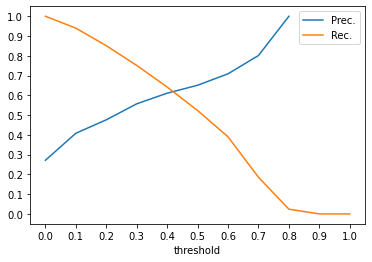

In [222]:
plt.plot(df_pr_r['threshold'], df_pr_r['precision'], label='Prec.')
plt.plot(df_pr_r['threshold'], df_pr_r['recall'], label='Rec.')
plt.legend()
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel('threshold')
plt.show()

In [283]:
# random model
np.random.seed(1)
y_randomModel = np.random.uniform(0, 1, len(y_valid))
df_random = calc_prec_rec(y_valid, y_randomModel)

In [284]:
# ideal model
num_neg = (y_valid == 0).sum()
num_pos = (y_valid == 1).sum()

y_idealModel = np.repeat([0, 1], [num_neg, num_pos])
y_predIdeal = np.linspace(0, 1, num_neg + num_pos)

df_ideal_pr_r = calc_prec_rec(y_ideal, y_predIdeal)

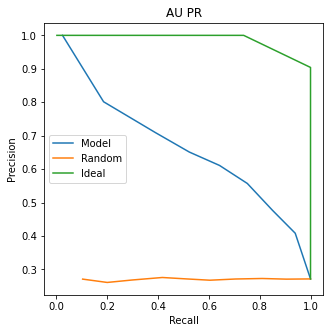

In [285]:
plt.figure(figsize=(5, 5))
plt.plot(df_pr_r['recall'], df_pr_r['precision'], label='Model')
plt.plot(df_random['recall'], df_random['precision'], label='Random')
plt.plot(df_ideal_pr_r['recall'], df_ideal_pr_r['precision'], label='Ideal')

plt.title('AU PR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Calc f1 & intersection with sklearn

In [258]:
from sklearn.metrics import precision_recall_curve, f1_score

f1_score(y_valid, y_churn)

0.5799648506151143

In [259]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

pr, r, th = precision_recall_curve(y_valid, y_pred)

pr = pd.Series(pr[:-1])
r = pd.Series(r[:-1])
th = pd.Series(th)

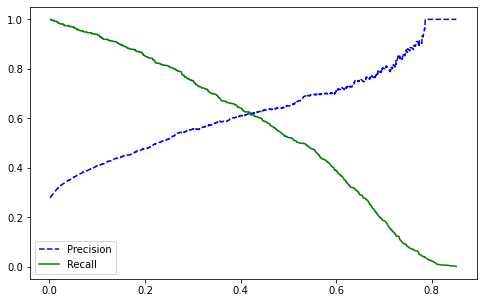

In [262]:
fig = plt.figure(figsize= (8,5))
plt.plot(th, pr, "b--", label="Precision")
plt.plot(th, r, "g-", label="Recall")
plt.legend()
plt.show()

# ROC curve and AUC score

**Roc curve** <br>
receiver operating characteristic

In [64]:
# FPR & TPR:
# 1) false positive rate (false_pos/all negative)
#   FPR = FP / (FP + TN) - out of "actual neg"
# 2) true positive rate (true_pos/all positive)
#   TPR = TP / (TP + FN) - out of "actual pos"
fpr = 177 / (177 + 1517)
tpr = 330 / (330 + 301)

In [65]:
fpr * 100
# predicted fraction as churning when they're not
# small number is good, few false positives

10.448642266824084

In [66]:
tpr * 100
# predicted fraction as churning among all who churned
# !!! similar to Recall

52.29793977812995

In [67]:
def fpr_tpr_df(y_vl, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        true_positive = ((y_pred >= t) & (y_vl == 1)).sum()
        true_negative = ((y_pred < t) & (y_vl == 0)).sum()
        false_positive = ((y_pred >= t) & (y_vl == 0)).sum()
        false_negative = ((y_pred < t) & (y_vl == 1)).sum()

        scores.append([t, true_positive, true_negative,
                         false_positive, false_negative])
        
    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
    df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn'])
    df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])

    return df_scores


# Below is for next plot

In [68]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    tp = ((y_pred >= t) & (y_valid == 1)).sum()
    fp = ((y_pred >= t) & (y_valid == 0)).sum()
    fn = ((y_pred < t) & (y_valid == 1)).sum()
    tn = ((y_pred < t) & (y_valid == 0)).sum()
    scores.append([t, tp, fp, fn, tn])

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [69]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,631,1694,0,0
10,0.1,593,860,38,834
20,0.2,537,591,94,1103
30,0.3,474,377,157,1317
40,0.4,405,258,226,1436
50,0.5,330,177,301,1517
60,0.6,246,101,385,1593
70,0.7,117,29,514,1665
80,0.8,15,0,616,1694
90,0.9,0,0,631,1694


In [70]:
df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn'])
# FP / FP + TN
df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
# TP / TP + FN

In [71]:
df_scores[::10]

,threshold,tp,fp,fn,tn,fpr,tpr
0,0.0,631,1694,0,0,1.000000,1.000000
10,0.1,593,860,38,834,0.507674,0.939778
20,0.2,537,591,94,1103,0.348878,0.851030
30,0.3,474,377,157,1317,0.222550,0.751189
40,0.4,405,258,226,1436,0.152302,0.641838
50,0.5,330,177,301,1517,0.104486,0.522979
60,0.6,246,101,385,1593,0.059622,0.389857
70,0.7,117,29,514,1665,0.017119,0.185420
80,0.8,15,0,616,1694,0.000000,0.023772
90,0.9,0,0,631,1694,0.000000,0.000000


In [72]:
conf_table_s = np.array(
     # pred. pos. pred. neg. 
    [
    [true_pos_s, false_neg_s],   # actual positive
    [false_pos_s, true_neg_s]    # actual negative
    ]
)

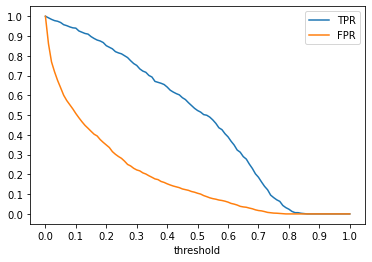

In [73]:
plt.plot(df_scores['threshold'], df_scores['tpr'], label='TPR')
plt.plot(df_scores['threshold'], df_scores['fpr'], label='FPR')
plt.legend()
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel('threshold')
plt.show()

# Look at threshold on X-Axis and analyze TPR/FPR by Y-Axis

<h3>ideally FPR should go down very fast (fewer false positives)
BUT ideally TPR should go down SLOWLY (more true positives)
   </h3>

In [74]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, len(y_valid))
# as if `y_rand` has predictions
# use function
df_rand = fpr_tpr_df(y_valid, y_rand)
df_rand[::10]

,threshold,tp,tn,fp,fn,fpr,tpr
0,0.0,631,0,1694,0,1.000000,1.000000
10,0.1,571,156,1538,60,0.907910,0.904913
20,0.2,511,331,1363,120,0.804604,0.809826
30,0.3,445,498,1196,186,0.706021,0.705230
40,0.4,381,651,1043,250,0.615702,0.603803
50,0.5,324,824,870,307,0.513577,0.513471
60,0.6,263,1003,691,368,0.407910,0.416799
70,0.7,188,1181,513,443,0.302834,0.297940
80,0.8,126,1337,357,505,0.210744,0.199683
90,0.9,65,1519,175,566,0.103306,0.103011


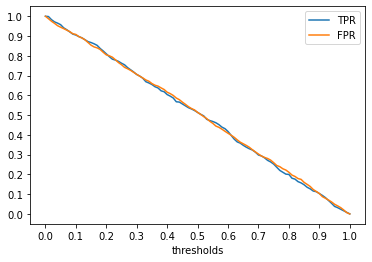

In [75]:
plt.plot(df_rand['threshold'], df_rand['tpr'], label='TPR')
plt.plot(df_rand['threshold'], df_rand['fpr'], label='FPR')
plt.legend()
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel('thresholds')
plt.show()
# if FPR is 100% -> all non-churning customers
# are predicted to be churning

# if TPR is 100% -> all churning customers are really churning

# Look at threshold on X-Axis and analyze TPR/FPR by Y-Axis

In [76]:
# take data from validation set
num_neg = (y_valid == 0).sum()
num_pos = (y_valid == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_predIdeal = np.linspace(0, 1, num_neg + num_pos)

df_ideal = fpr_tpr_df(y_ideal, y_predIdeal)

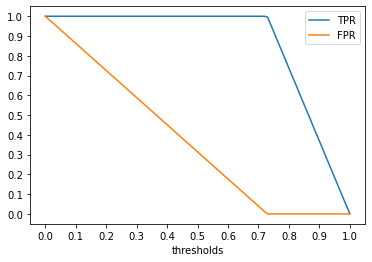

In [77]:
plt.plot(df_ideal['threshold'], df_ideal['tpr'], label='TPR')
plt.plot(df_ideal['threshold'], df_ideal['fpr'], label='FPR')
plt.legend()
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel('thresholds')
plt.show()

# ROC Curve

<h3>In ROC Curve FPR & TPR are plotted against each other instead of against various thresholds</h3>

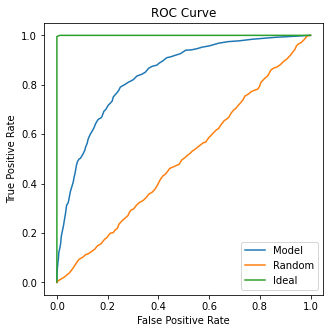

In [78]:
plt.figure(figsize=(5, 5))
plt.plot(df_scores['fpr'], df_scores['tpr'], label='Model')
plt.plot(df_rand['fpr'], df_rand['tpr'], label='Random')
plt.plot(df_ideal['fpr'], df_ideal['tpr'], label='Ideal')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

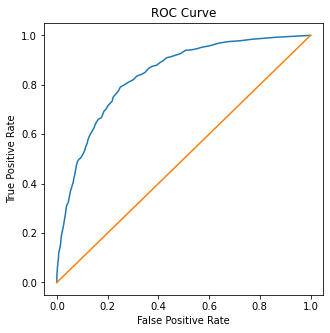

In [79]:
# we can reduce the amount of code of the above graph:
plt.figure(figsize=(5, 5))
plt.plot(df_scores['fpr'], df_scores['tpr'])
plt.plot([0, 1], [0, 1])

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

<h2>We can use sklearn not to build all the stuff by ourselves</h2>

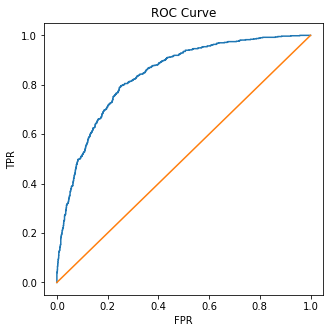

In [80]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, y_pred)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Good model goes up as much as can before turning right. Poor models have more "false positives" from the beginning => go right earlier

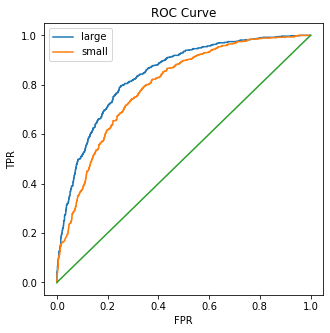

In [81]:
fpr_big, tpr_big, _ = roc_curve(y_valid, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_valid, y_predictSmall)

plt.figure(figsize=(5, 5))

plt.plot(fpr_big, tpr_big, label='large')
plt.plot(fpr_small, tpr_small, label='small')
plt.plot([0, 1], [0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

<h3>AUC</h3>

In [82]:
from sklearn.metrics import auc
auc(df_scores['fpr'], df_scores['tpr'])

0.8389898532529277

In [83]:
df_score_small = fpr_tpr_df(y_valid, y_predictSmall)
auc(df_score_small['fpr'], df_score_small['tpr'])

0.7904995163315289

**If we don't need ROC Curve itself, but only AUC, then we're able to use sklearn with pertinent method**

In [84]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, y_pred)

0.8393439509633142

In [85]:
roc_auc_score(y_valid, y_predictSmall)

0.792368235423991

In [86]:
# len() of y_pred == y_valid =>
# 1) select == 0 or 1 2) opt from y_pred
neg = y_pred[y_valid == 0]
pos = y_pred[y_valid == 1]

np.random.seed(1)
neg_choice = np.random.randint(low=0, high=len(neg), size=10000)
pos_choice = np.random.randint(low=0, high=len(pos), size=10000)
(pos[pos_choice] > neg[neg_choice]).mean()
# prob. the score of pos. item is higher that
# score of neg. item.
# It roughly corresponds to AUC (and should do so)

0.8377

# Parameter Tuning

In [87]:
def train(df, y_part):
    train = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train)
    X = dv.transform(train)
    
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y_part)
    
    return dv, model

def predict(df, dv, model):
    valid = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(valid)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [98]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

aucs = []

for trainIdx, validIdx in kfold.split(full_train):
    
# traverse 10 different splits of data
    df_train = full_train.iloc[trainIdx]
    df_valid = full_train.iloc[validIdx]
    
    y_train = df_train.churn.values
    y_valid = df_valid.churn.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_valid, dv, model)
    
    auc = roc_auc_score(y_valid, y_pred)
    aucs.append(auc)

In [89]:
[round(x, 3) for x in aucs]
# as n_splits = 10 => 10 different numbers which are 10 
# AUC scores evaluated on 10 diff. validation folds

[0.849, 0.841, 0.859, 0.833, 0.824, 0.842, 0.844, 0.822, 0.845, 0.861]

In [90]:
# mean and std
print(f"{round(np.mean(aucs), 3)} +- {round(np.std(aucs), 3)}")

0.842 +- 0.012


<h2>Let's find the best `C` for our model. I.e. best
regularization</h2>

In [161]:
def train(df, y_part, C):
    train = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train)
    X = dv.transform(train)
    
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y_part)
    
    return dv, model

In [162]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []
    
    for trainIdx, validIdx in kfold.split(full_train):
        df_train = full_train.iloc[trainIdx]
        df_valid = full_train.iloc[validIdx]
        
        y_train = df_train.churn.values
        y_valid = df_valid.churn.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_valid, dv, model)
        
        auc = roc_auc_score(y_valid, y_pred)
        aucs.append(auc)
    
    print(f"C={C} auc = {round(np.mean(aucs), 3)} +- {round(np.std(aucs), 3)}")
    

C=0.001 auc = 0.825 +- 0.013
C=0.01 auc = 0.839 +- 0.009
C=0.1 auc = 0.841 +- 0.008
C=0.5 auc = 0.841 +- 0.007
C=1 auc = 0.841 +- 0.007
C=10 auc = 0.841 +- 0.007


# Using model

In [163]:
y_train = full_train.churn.values
y_test = df_test.churn.values

dv, model = train(full_train, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print(f"{round(auc, 3)}")

0.858


In [164]:
def predict_single(customer, dv, model):
    X = dv.transform([customer])
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred[0]

In [165]:
customer = {
    'customerid': '8879-zkjof',
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'no',
    'dependents': 'no',
    'tenure': 41,
    'phoneservice': 'yes',
    'multiplelines': 'no',
    'internetservice': 'dsl',
    'onlinesecurity': 'yes',
    'onlinebackup': 'no',
    'deviceprotection': 'yes',
    'techsupport': 'yes',
    'streamingtv': 'yes',
    'streamingmovies': 'yes',
    'contract': 'one_year',
    'paperlessbilling': 'yes',
    'paymentmethod': 'bank_transfer_(automatic)',
    'monthlycharges': 79.85,
    'totalcharges': 3320.75,
}

In [166]:
# to ease the process we
# create separate function
predict_single(customer, dv, model)

0.059605948348965786

# Deployment

In [167]:
import pickle

# 'b' is crucial as `pickle` uses
# binary files for serializing
with open('churn-model.bin', 'wb') as churn_model:
    pickle.dump((dv, model), churn_model)

In [168]:
with open('churn-model.bin',  'rb') as churn_model_des:
    dv, model = pickle.load(churn_model_des)

In [170]:
# we have site running and make request to it
import requests

url = 'http://192.168.0.20:8085/predict'
response = requests.post(url, json=customer)
result = response.json()
result

{'churn': False, 'prob.': 0.06}